In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import Required Libraries
import os
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Set Paths
# base_dir = "/content/drive/MyDrive/Project 5: Jaundice Tracker/jaundice_dataset/jaundice_preprocessed"
base_dir ="/content/drive/MyDrive/Project 5: Jaundice Tracker/Final EfficientNet B3/jaundice_preprocessed-new"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")



In [3]:
# Image Parameters
target_size = (224, 224)  # EfficientNetB3 input size
batch_size = 32

# Create data generators
train_datagen = ImageDataGenerator(
    rotation_range=25, # Increased
    width_shift_range=0.3, # Increased
    height_shift_range=0.3, # Increased
    horizontal_flip=True,
    brightness_range=(0.8,1.2),
    fill_mode="nearest"
)
val_datagen = ImageDataGenerator()

# Load Images Directly From Folders
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary"
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

Found 1109 images belonging to 2 classes.
Found 805 images belonging to 2 classes.
Found 774 images belonging to 2 classes.


In [4]:
print(train_generator.class_indices)


{'jaundice': 0, 'normal': 1}


In [5]:
# Compute class weights based on the training data class distribution
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Computed Class Weights:", class_weights)

Computed Class Weights: {0: np.float64(1.0100182149362478), 1: np.float64(0.9901785714285715)}


In [6]:
# Load EfficientNetB3 Model (Without Top Layers)
base_model = EfficientNetB3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable= False # Freeze Base Model Initially

# Add Custom Layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)  # Reduced dropout rate
x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output_layer = Dense(1, activation="sigmoid")(x)  # Ensure 'x' is passed into the layer, Binary Classification

In [7]:
# Create Final Model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile Model (Initial Training)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)
# Callbacks for Learning Rate Adjustment
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)

# Train Model (Initial Phase w/ Frozen Base Model)
history = model.fit(
    train_generator,
    epochs=10, # Increased training epochs
    validation_data=val_generator,
    verbose=1,
    callbacks=[lr_scheduler, early_stopping],
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 356s 10s/step - accuracy: 0.6121 - loss: 0.8538 - val_accuracy: 0.7143 - val_loss: 0.5459 - learning_rate: 0.0010
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 318s 9s/step - accuracy: 0.7301 - loss: 0.5428 - val_accuracy: 0.8186 - val_loss: 0.4519 - learning_rate: 0.0010
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 325s 9s/step - accuracy: 0.8000 - loss: 0.4361 - val_accuracy: 0.8671 - val_loss: 0.3933 - learning_rate: 0.0010
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 334s 10s/step - accuracy: 0.8013 - loss: 0.3984 - val_accuracy: 0.8820 - val_loss: 0.3129 - learning_rate: 0.0010
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 329s 10s/step - accuracy: 0.8523 - loss: 0.3486 - val_accuracy: 0.8758 - val_loss: 0.2935 - learning_rate: 0.0010
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 421s 12s/step - accuracy: 0.8484 - loss: 0.3570 - val_accuracy: 0.9081 - val_loss: 0.2555 - learning_rate: 0.0010
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 429s 12s/step - accuracy: 0.8513 - loss: 0.3322 - va

26/26 ━━━━━━━━━━━━━━━━━━━━ 146s 5s/step


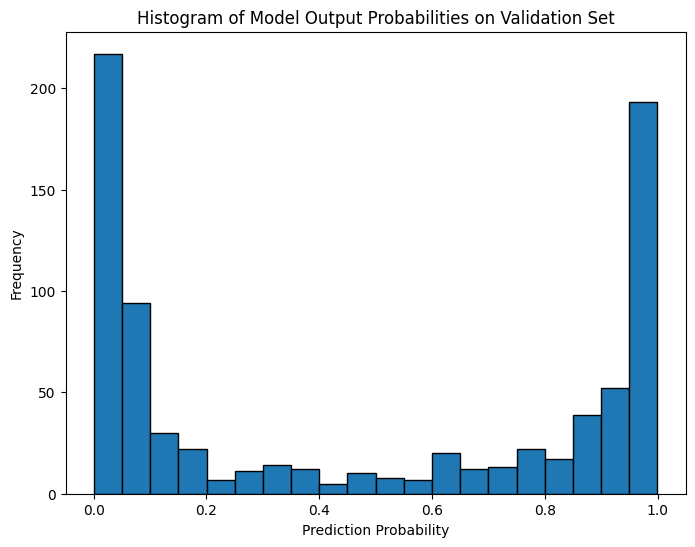

In [8]:
# Ensure the generator is reset to start from the beginning
val_generator.reset()

# Predict probabilities on the entire validation set
# The steps parameter is set to cover all samples in the generator
val_steps = np.ceil(val_generator.samples / val_generator.batch_size)
# Convert val_steps to an integer
val_steps = int(val_steps)
val_probs = model.predict(val_generator, steps=val_steps, verbose=1)

# Optionally, if you want to flatten the array (in case it's in 2D format)
val_probs = val_probs.flatten()

# Plot the histogram of predicted probabilities
plt.figure(figsize=(8, 6))
plt.hist(val_probs, bins=20, edgecolor="k")
plt.xlabel("Prediction Probability")
plt.ylabel("Frequency")
plt.title("Histogram of Model Output Probabilities on Validation Set")
plt.show()

In [9]:
# Gradual Unfreezing for Fine-Tuning
for layer in base_model.layers[:150]: # Keep first 150 layers frozen initially
  layer.trainable = False
for layer in base_model.layers[150:]: # Unfreeze last 50 layers
  layer.trainable = True

# Compile Model with Lower Learning Rate for Fine-Tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Lower LR for Fine-Tuning
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)
# Continue Training (Fine-Tuning Phase)
history_finetune = model.fit(
    train_generator,
    epochs=15, # Fine Tuning Phase
    validation_data=val_generator,
    verbose=1,
    callbacks=[lr_scheduler, early_stopping],
    class_weight=class_weights
)

Epoch 1/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 618s 16s/step - accuracy: 0.7147 - loss: 0.6505 - val_accuracy: 0.9304 - val_loss: 0.1764 - learning_rate: 1.0000e-05
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 536s 15s/step - accuracy: 0.7474 - loss: 0.6362 - val_accuracy: 0.9242 - val_loss: 0.2068 - learning_rate: 1.0000e-05
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 563s 15s/step - accuracy: 0.7773 - loss: 0.5200 - val_accuracy: 0.9118 - val_loss: 0.2167 - learning_rate: 1.0000e-05
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7518 - loss: 0.6003 
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
35/35 ━━━━━━━━━━━━━━━━━━━━ 542s 16s/step - accuracy: 0.7524 - loss: 0.5984 - val_accuracy: 0.8944 - val_loss: 0.2349 - learning_rate: 1.0000e-05
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 550s 15s/step - accuracy: 0.7909 - loss: 0.4629 - val_accuracy: 0.8845 - val_loss: 0.2566 - learning_rate: 5.0000e-06
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 519s 15s/step - accuracy: 0.7874

26/26 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step


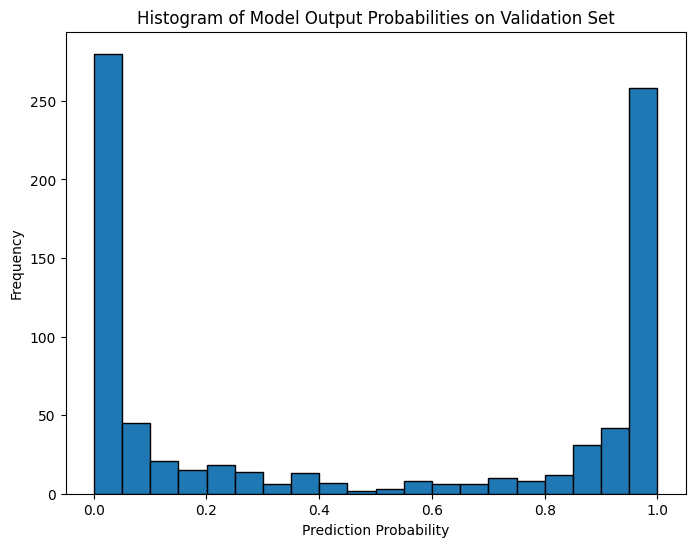

In [10]:
# Ensure the generator is reset to start from the beginning
val_generator.reset()

# Predict probabilities on the entire validation set
# The steps parameter is set to cover all samples in the generator
val_steps = np.ceil(val_generator.samples / val_generator.batch_size)
# Convert val_steps to an integer
val_steps = int(val_steps)
val_probs = model.predict(val_generator, steps=val_steps, verbose=1)

# Optionally, if you want to flatten the array (in case it's in 2D format)
val_probs = val_probs.flatten()

# Plot the histogram of predicted probabilities
plt.figure(figsize=(8, 6))
plt.hist(val_probs, bins=20, edgecolor="k")
plt.xlabel("Prediction Probability")
plt.ylabel("Frequency")
plt.title("Histogram of Model Output Probabilities on Validation Set")
plt.show()

In [11]:
# Save Model to Google Drive
model_save_path = "/content/drive/MyDrive/jaundice_detection_modelv2.keras"
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")

Model saved at: /content/drive/MyDrive/jaundice_detection_modelv2.keras


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Evaluate Model
y_pred_probs = model.predict(test_generator)
# Round the probabilities to 2 decimal places
y_pred_probs = np.round(y_pred_probs, 2)
y_pred = (y_pred_probs > 0.5).astype(int)

# Get True Labels from Generator
y_true = test_generator.classes


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_probs)

25/25 ━━━━━━━━━━━━━━━━━━━━ 262s 11s/step



Final Test Results:

   Metric    Value
 Accuracy 0.922481
Precision 0.946092
   Recall 0.897698
 F1 Score 0.921260
      AUC 0.980772


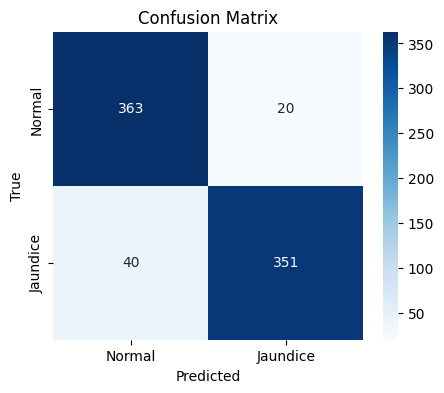

In [14]:
# Display results as a table
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"],
    "Value" : [accuracy, precision, recall, f1, auc]
})
print("\nFinal Test Results:\n")
print(metrics_df.to_string(index=False))

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Jaundice"], yticklabels=["Normal", "Jaundice"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

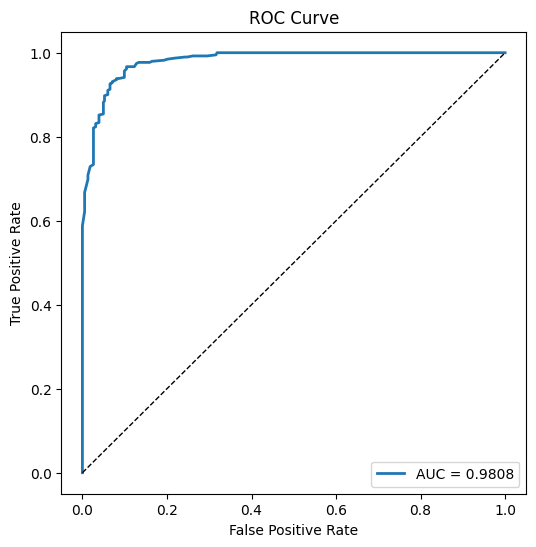

In [15]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true,y_pred_probs)
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,label=f"AUC = {auc:.4f}", linewidth=2)
plt.plot([0,1],[0,1], 'k--', linewidth=1) # Random Classifier Line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

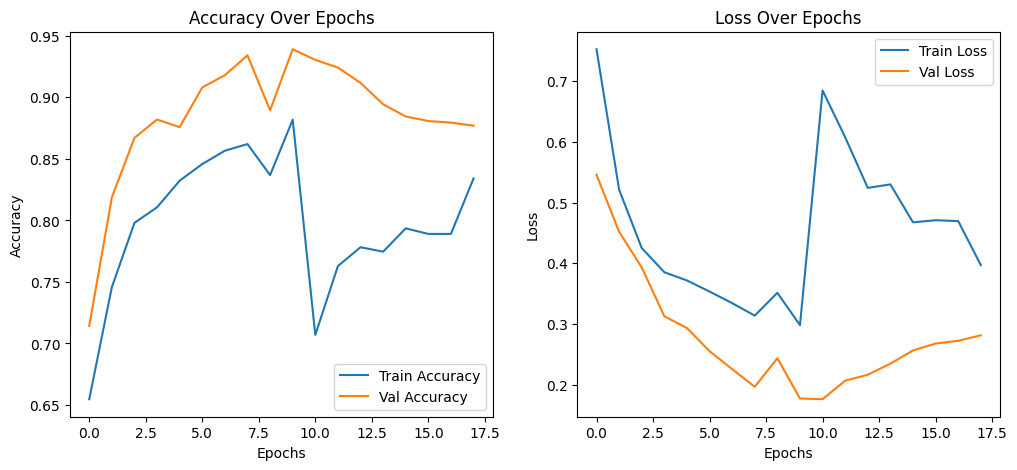

In [16]:
# Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train_acc = history.history["accuracy"] + history_finetune.history["accuracy"]
val_acc = history.history["val_accuracy"] + history_finetune.history["val_accuracy"]

plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Over Epochs")


plt.subplot(1, 2, 2)
train_loss = history.history["loss"] + history_finetune.history["loss"]
val_loss = history.history["val_loss"] + history_finetune.history["val_loss"]

plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Over Epochs")

plt.show()

In [19]:
import os

# Update this path to your dataset root directory
dataset_dir = "/content/drive/MyDrive/Project 5: Jaundice Tracker/Final EfficientNet B3/jaundice_preprocessed-new"

# Folders could be named 'train', 'val', and 'test', or similar.
splits = ['train', 'val', 'test']

for split in splits:
    split_dir = os.path.join(dataset_dir, split)
    print(f"\n{split.upper()} set:")
    # List all subdirectories (each representing a class)
    for class_folder in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_folder)
        if os.path.isdir(class_path):
            # Count files in the class folder. You might want to filter by image extensions.
            images = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            count = len(images)
            print(f"  {class_folder}: {count} images")



TRAIN set:
  jaundice: 549 images
  normal: 560 images

VAL set:
  normal: 402 images
  jaundice: 403 images

TEST set:
  normal: 391 images
  jaundice: 383 images


In [21]:
import os

# Update this path to your dataset root directory
dataset_dir = "/content/drive/MyDrive/Project 5: Jaundice Tracker/Final EfficientNet B3/jaundice_originalimages-new"

# Folders could be named 'train', 'val', and 'test', or similar.
splits = ['train', 'val', 'test']

for split in splits:
    split_dir = os.path.join(dataset_dir, split)
    print(f"\n{split.upper()} set:")
    # List all subdirectories (each representing a class)
    for class_folder in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_folder)
        if os.path.isdir(class_path):
            # Count files in the class folder. You might want to filter by image extensions.
            images = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            count = len(images)
            print(f"  {class_folder}: {count} images")



TRAIN set:
  normal: 448 images
  jaundice: 448 images

VAL set:
  normal: 56 images
  jaundice: 56 images

TEST set:
  jaundice: 56 images
  normal: 56 images
